In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import numpy as np
from matplotlib import pyplot as plt
import os
import pwlf
import os
from surface_dynamics.all import *
from Library import *
from Library import Section
import math
from time import time
import copy
from scipy import integrate
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify
import traceback
import dill

In [2]:
def poincare_details(perm, vecs0):
    #find the generators of each cusp of the STS
    generators = []
    a = perm.veech_group().cusps()
    m = perm.veech_group().cusp_data(a[0])[0]
    generators.append(m.matrix())
    #find the eigenvectors for each generator and make sure they are 1
    eigs = []
    for matrix in generators:
        eig1, eig2 = matrix.eigenvalues()
        if eig1 == eig2:
            if eig1 == 1:
                eigs.append(eig1)
            else:
                raise ValueError("Eigenvalue not equal to 1")
        else:
            raise ValueError("Different eigenvalues")
    #find the eigenvectors for each generator
    eigenvecs = []
    for matrix in generators:
        vec = matrix.eigenvectors_right()[0][1][0]
        vec = np.array([[vec[0]],[vec[1]]])
        eigenvecs.append(vec)
    #find the magnitude, slope, x-direction, and y-direction of each eigenvector
    saddle_vecs = []
    for vec in eigenvecs:
        mag_vec = ((vec[0]**2 + vec[1]**2)**0.5)[0]
        if vec[0] == 0:
            slope_vec = float("inf")
        else:
            slope_vec = (vec[1]/vec[0])[0]

        if vec[0] >= 0:
            x_sign_vec = 1
        else:
            x_sign_vec = -1
        if vec[1] >= 0:
            y_sign_vec = 1
        else:
            y_sign_vec = -1

        saddle_vec = None
        check = 0

        #find the magnitude, slope, x-direction, and y-direction of each saddle connection
        for saddle in vecs0:
            mag_saddle = ((saddle[0]**2 + saddle[1]**2)**0.5)[0]
            if saddle[0] == 0:
                slope_saddle = float("inf")
            else:
                slope_saddle = (saddle[1]/saddle[0])[0]

            if saddle[0] >= 0:
                x_sign_saddle = 1
            else:
                x_sign_saddle = -1
            if saddle[1] >= 0:
                y_sign_saddle = 1
            else:
                y_sign_saddle = -1

            #find the smallest saddle connection that is in the same direction and has the same slope as the given eigenvector and add it to a list
            if slope_vec == slope_saddle:
                if x_sign_vec == x_sign_saddle:
                    if y_sign_vec == y_sign_saddle:
                        if check == 0:
                            saddle_vec = saddle
                            mag = mag_saddle
                            check += 1
                        elif mag_saddle < mag:
                            saddle_vec = saddle
                            mag = mag_saddle
        if check == 0:
            raise ValueError(f"No saddle vec for eigenvector {vec}")
        saddle_vecs.append(saddle_vec)
    #find the counter-clockwise angle from the x-axis to the eigenvectors
    thetas = []
    for i in range(len(saddle_vecs)):
        mag = (saddle_vecs[i][0]**2 + saddle_vecs[i][1]**2)**0.5
        theta = np.arccos(np.dot(np.array([[1,0]]),saddle_vecs[i])/mag)
        if saddle_vecs[i][1] < 0:
            theta = 2 * math.pi - theta
        thetas.append(theta)
    #find the rotation matrix that takes the vector (1,0) to the vector in the direction of each eigenvector
    rots = []
    for theta in thetas:
        rot = np.array([[round(np.cos(theta)[0][0],5),round(-np.sin(theta)[0][0],5)],[round(np.sin(theta)[0][0],5), round(np.cos(theta)[0][0],5)]])
        rots.append(rot)

    #find a constant value such that mult*rot@(1,0) = saddle_vec while accounting for rounding errors and zero matrix inputs
    mults = []
    for i in range(len(rots)):
        matrix = rots[i]@np.array([[1],[0]])
        if matrix[0][0] != 0:
            mult1 = saddle_vecs[i][0][0]/matrix[0][0]
        else:
            mult1 = 0
        if matrix[1][0] != 0:
            mult2 = saddle_vecs[i][1][0]/matrix[1][0]
        else:
            mult2 = 0
        if mult1 != 0 and mult2 == 0:
            mult = mult1
        elif mult1 == 0 and mult2 != 0:
            mult = mult2
        elif mult1 == 0 and mult2 == 0:
            raise ValueError('both mults equal zero')
        elif abs(mult1 - mult2) <= 0.001:
            mult = mult1
        elif abs(mult1 - mult2) >= 0.001:
            raise ValueError(f'mults are different {mult1}, {mult2}')
        mults.append(mult)
        mult1 = None
        mult2 = None
        mult = None
    #find c_inv and c
    Cs = []
    C_invs = []
    for i in range(len(mults)):
        c_inv = mults[i]*rots[i]
        c = np.linalg.inv(c_inv)
        Cs.append(c)
        C_invs.append(c_inv)
    #alpha is the top right value of the matrix M = c @ generator @ c_inv. M must have 1s on the diagonal and 0 in the bottom left
    alphas = []
    Ms = []
    for i in range(len(generators)):
        M = Cs[i]@generators[i]@C_invs[i]
        Ms.append(M)
        if M[1][0] >= 1/1000000 and M[1][0] <= -1/1000000:
            raise ValueError(f"Wrong conjugate matrix\nC: {Cs[i]}\nC_inv: {C_invs[i]}\nM: {M}\ngenerator: {generators[i]}")
        alphas.append(round(M[0][1], 5))
    return alphas, Cs, C_invs, eigs, Ms, generators, eigenvecs

[[1.0, 1.0], [3.0, 2.0], [5.0, 3.0], [4.0, 2.0], [3.0, 1.0], [4.0, 1.0], [5.0, 1.0], [6.0, 1.0], [7.0, 1.0], [8.0, 1.0], [9.0, 1.0], [28.0, 3.0], [47.0, 5.0], [29.0, 3.0], [20.0, 2.0], [11.0, 1.0], [12.0, 1.0]]


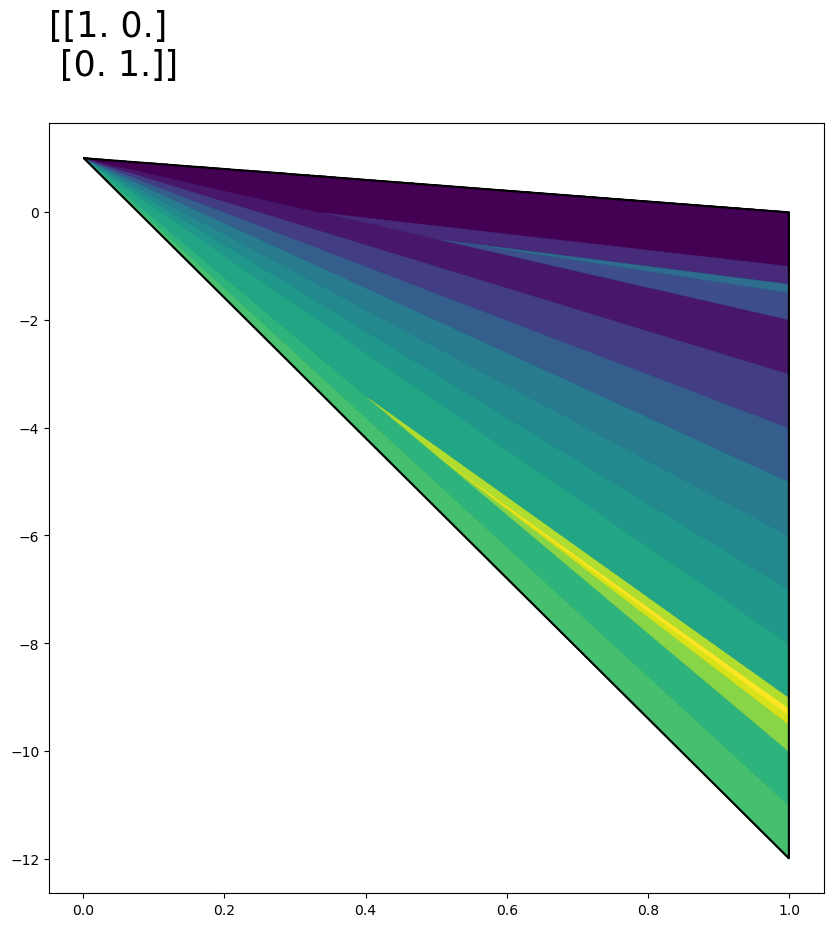

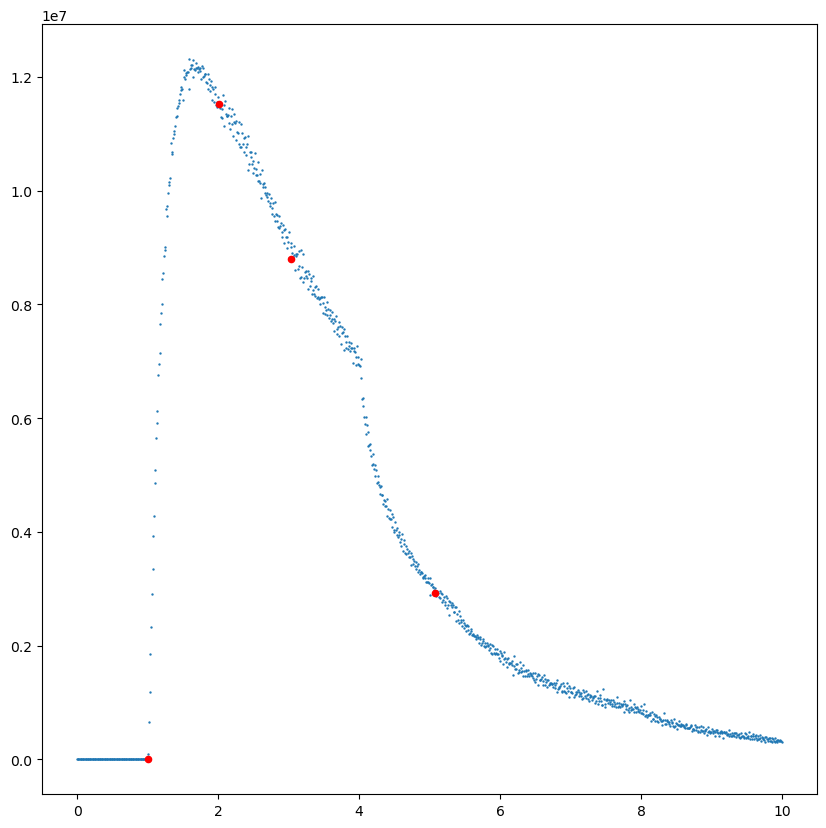

<Figure size 640x480 with 0 Axes>

In [3]:
# 7-0, 7-3, 7-7, 7-19, 7-29, 7-41
indexes = [29]
n_squares = 7
ps = []
for index in indexes:
    permutations = perms_list(n_squares)
    perm = permutations[index]
    
    vec_file = "vecs" + str(n_squares) + "-" + str(index) + ".npy"
    vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))
    
    vecs1 = []
    for vec in vecs0:
        if(abs(vec[0][0]) <= 50):
            if(abs(vec[1][0]) <= 50):
                vecs1.append(vec)
    len(vecs1)

    a, c, C_invs, e, Ms, generators, eigenvecs = poincare_details(perm, vecs1)
    
    dx = 0.0005
    vecs, x_vals, m0, m1, x0, y0, dx_y, z = setup(a[0], c[0], e[0], vecs1, dx, True)
    df = winners(vecs, x_vals, m0, m1, y0, dx, dx_y)
    df.to_csv(os.path.join("results", f"{n_squares} - {index}", "df - " + str(0)), index=False)

    plot(df, vecs, c[0], 0, n_squares, index, test = True)
    
    sec_list = sec_setup(df, dx_y)
    secs = sec_comp(sec_list, dx)

    with open(os.path.join("results", f"{n_squares} - {index}", "secs*" + ".dill"), 'wb') as f:
        dill.dump(secs, f)
        
    times = time_comp(secs)
    p = pdf(list(df["time"]), times, dx, n_squares, index, 0, test = False)
    ps.append(p)
        

In [79]:
%store ps
%store total

Stored 'ps' (list)
Stored 'total' (list)


In [2]:
%store -r ps
%store -r total

In [34]:
n_squares = 7
index = 0
j = 0

permutations = perms_list(n_squares)
perm = permutations[index]

vec_file = "vecs" + str(n_squares) + "-" + str(index) + ".npy"
vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))

with open(os.path.join("results", f"{n_squares} - {index}", "setup.dill"), 'rb') as f:
    loaded_data = dill.load(f)
a,c,e,g = loaded_data

df = read_df(n_squares, index, j)

with open(os.path.join("results", f"{n_squares} - {index}", f"secs - {j}.dill"), 'rb') as f:
    secs = dill.load(f)

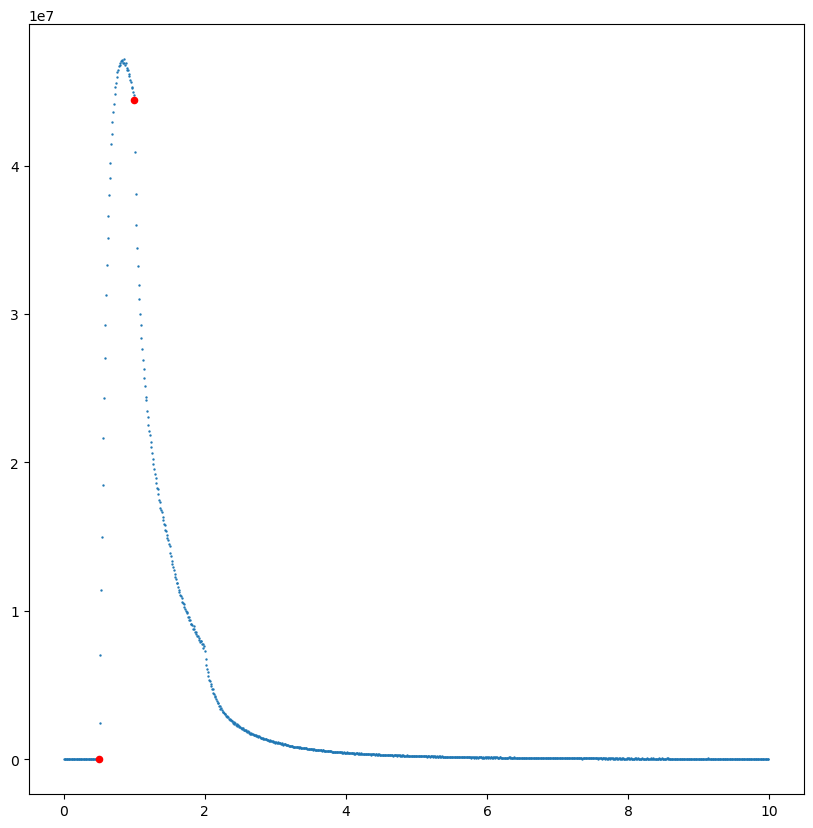

<Figure size 640x480 with 0 Axes>

In [23]:
p0 = pdf(list(df["time"]), [0.5,1], dx, n_squares, index, 0, test = False)

In [42]:
total = []
hall = []
for i in range(len(ps[0])):
    total.append(ps[0][i])
    total[i] += 3*ps[0][i]
    total[i] += 1*ps[1][i]
    total[i] += 1*ps[2][i]
    total[i] += 1*p1[i]
    total[i] += 1*ps[4][i]
    total[i] += 2*ps[5][i]
for i in range(len(ps[0])):
    hall.append(ps[0][i])
    hall[i] += 9*ps[0][i]

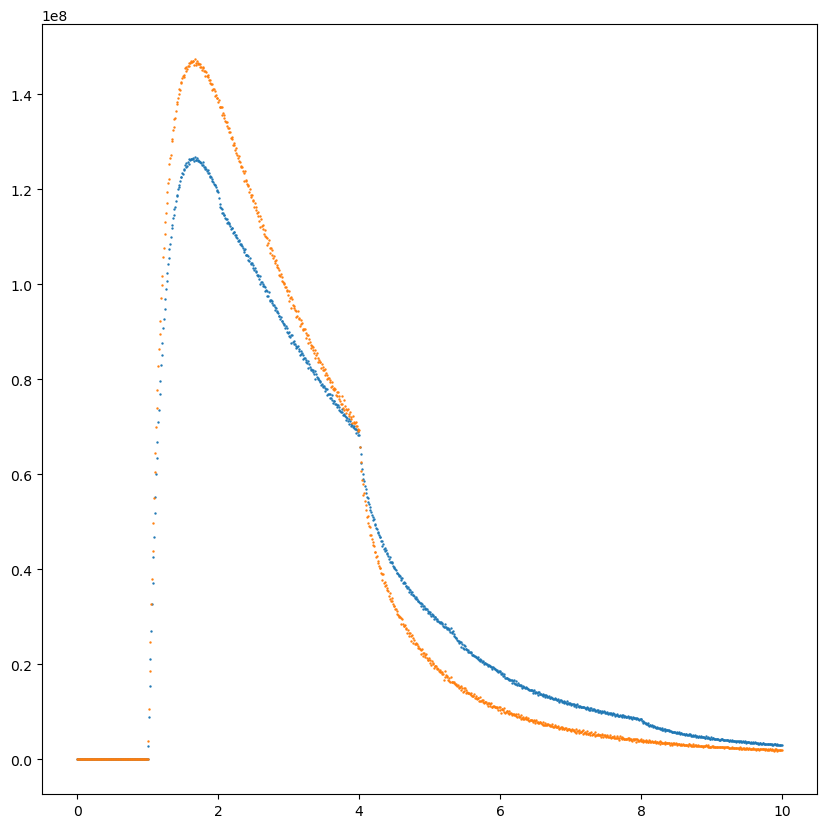

In [43]:
dx = 0.0005
times = list(np.arange(0, 10, 20*dx))
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(times, total, s = 0.5)
ax.scatter(times, hall, s = 0.5)

In [41]:
len(total), len(4*ps[0])

TypeError: object of type 'sage.rings.real_mpfr.RealNumber' has no len()

In [21]:
for p in ps:
    print(len(p))

200
200
200
200
200
200


In [67]:
ps[0]

[0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,
 0.000000000000000,


In [30]:
permutations = perms_list(n_squares)

In [31]:
perm = permutations[0]

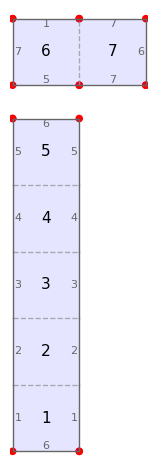

In [33]:
perm.show()

In [37]:
g[0][6], e[0][6]

(
[-119   90]  array([[1.        ], 
[-160  121],        [1.33333333]])
)